## Generowanie punktów

In [2]:
import matplotlib.pyplot as plt
import random, math
%matplotlib inline

In [3]:
def rand_in_box(bounds_x, bounds_y, total):
    low_x, high_x = bounds_x
    low_y, high_y = bounds_y
    return [(random.uniform(low_x, high_x), random.uniform(low_y, high_y)) for _ in range(total)]

In [4]:
def rand_on_circle(origin, radius, total):
    on_circle = lambda t: (org_x + radius * math.cos(t), org_y + radius * math.sin(t))
    org_x, org_y = origin
    return [on_circle(random.uniform(0, 2*math.pi)) for _ in range(total)]

In [5]:
def rand_on_polyline(polyline, total):
    n = len(polyline)
    points_x, points_y = zip(*polyline)
    vectors = [(points_x[i+1] - points_x[i], points_y[i+1]-points_y[i])
               for i in range(n-1)]

    def norm(vec): return math.sqrt(vec[0]**2 + vec[1]**2)
    partial_sum = [0]
    for i in range(1, n):
        partial_sum.append(partial_sum[i-1] + norm(vectors[i-1]))
    total_sum = partial_sum[n-1]

    def one_rand(vectors, partial_sum, total_sum):
        t = random.uniform(0, total_sum)
        i = 0
        while i < n:
            if (partial_sum[i]) <= t <= (partial_sum[i+1]):
                break
            i += 1
        theta = ((t-partial_sum[i])/norm(vectors[i]))
        final_x = points_x[i] + (points_x[i+1] - points_x[i]) * theta
        final_y = points_y[i] + (points_y[i+1] - points_y[i]) * theta
        return (final_x, final_y)
    return [one_rand(vectors, partial_sum, total_sum) for _ in range(total)]

In [14]:
points_a = rand_in_box((-100, 100), (-100, 100), 100)
points_b = rand_on_circle(origin=(0, 0), radius=10, total=100)
points_c = [(-10, 10), (-10,-10), (10,-10), (10,10)] + rand_on_polyline(polyline=[(10,10), (10,-10), (-10,-10), (-10,10), (10, 10)], total=(100-4))
points_d = [ (0, 0), (10, 0), (10, 10), (0, 10)] + rand_on_polyline(polyline=[(0, 0), (10, 0), (10, 10), (0, 10), (0, 0)], total = 25-4) + rand_on_polyline(polyline=[(0, 0), (5, 5), (10, 0), (5, 5), (10, 10), (5, 5), (0, 10), (5,5), (0, 0)], total = 20)

## Wizualizacja zbiorów punktów

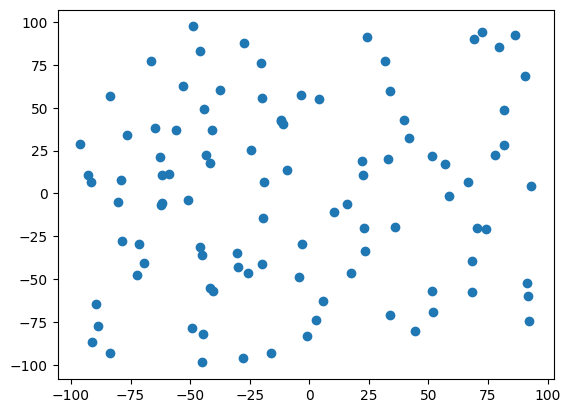

In [15]:
plt.scatter(*zip(*points_a))
plt.show()

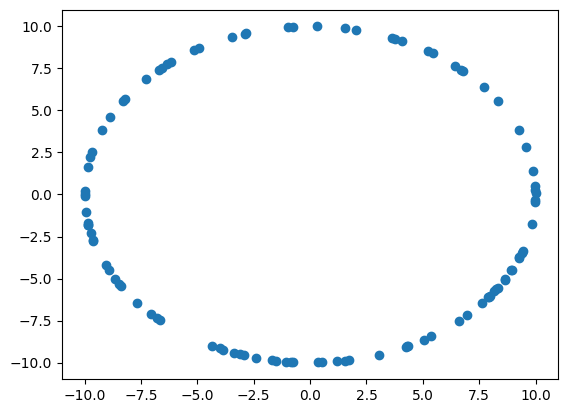

In [16]:
plt.scatter(*zip(*points_b))
plt.show()

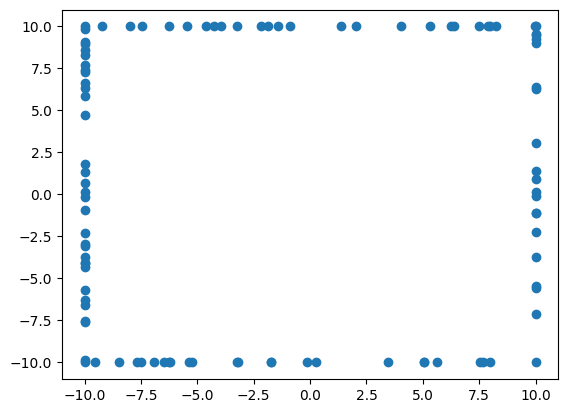

In [17]:
plt.scatter(*zip(*points_c))
plt.show()

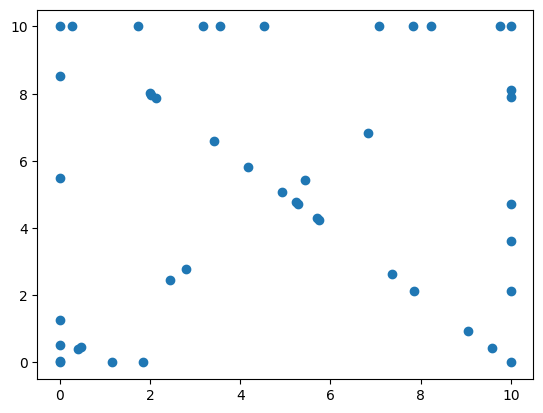

In [18]:
plt.scatter(*zip(*points_d))
plt.show()

# Implementacja algorytmu Jarvisa

In [40]:
# Helper funcitons
def orientation(p, q, r, tolerance=10**(-14)):
    determinant = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1]-q[1])
    if determinant > tolerance:
        return 1
    elif determinant < -tolerance:
        return -1
    else:
        return 0

def distance(p, q):
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

In [41]:
# Main implementation
def next_clockwise(points, p):
    n = len(points)
    q = (p+1) % n
    for i in range(n):
        orient = orientation(points[p], points[i], points[q]) 
        if orient == -1 or ( orient == 0 and distance(points[p], points[i]) >= distance(points[p], points[q])):
            q = i
    return q


def get_leftmost_index(points):
    result = 0
    for i, point in enumerate(points):
        if point[0] < points[result][0]:
            result = i
    return result


def jarvis_march(points):
    leftmost = get_leftmost_index(points)
    hull = [leftmost]
    p = next_clockwise(points, leftmost)
    while p != leftmost:
        hull.append(p)
        p = next_clockwise(points, p)
    return hull

### Rysowanie wyników algorytmu

In [34]:
def plot_hull(hull, points, with_points = False):
    final = list(map(lambda i: points[i], hull))
    final.append(final[0])
    plt.plot(*zip(*final))
    if with_points:
        plt.scatter(*zip(*points))
        plt.show()

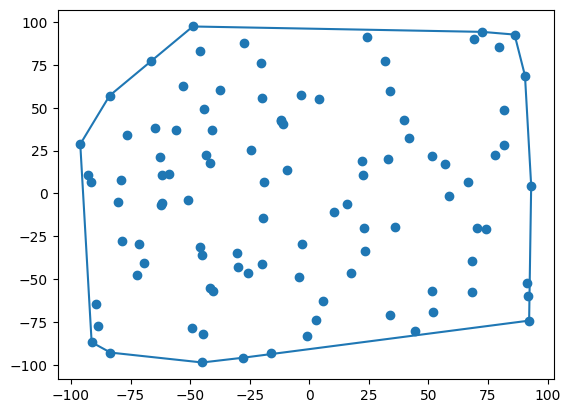

In [35]:
plot_hull(jarvis_march(points_a), points_a, True)

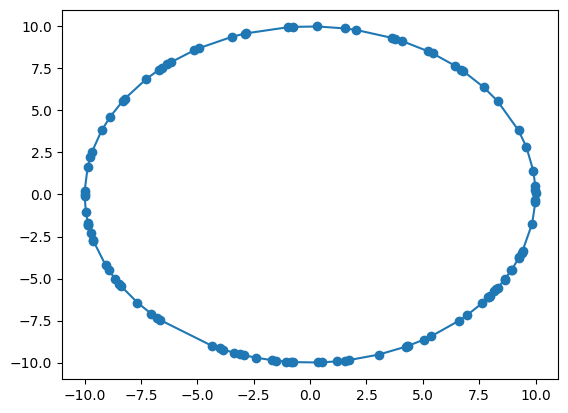

In [36]:
plot_hull(jarvis_march(points_b), points_b, True)

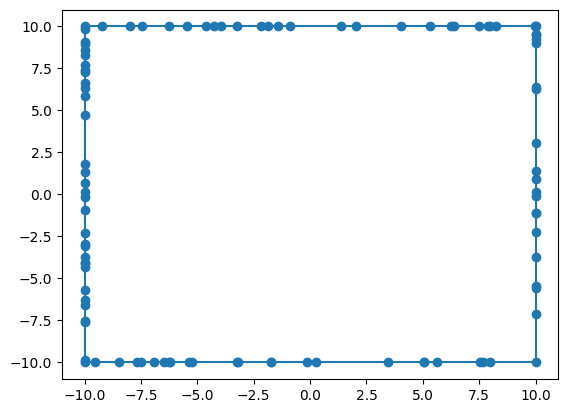

[0, 1, 2, 3]


In [38]:
plot_hull(jarvis_march(points_c), points_c, True)

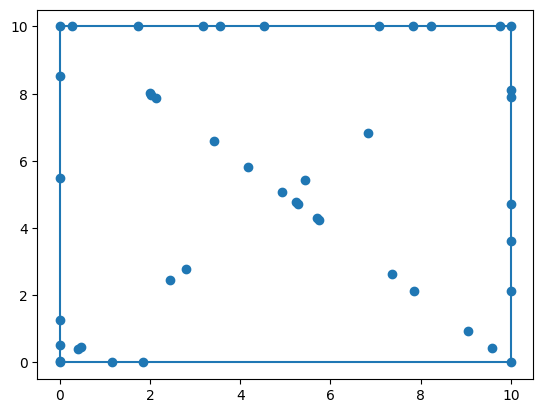

In [39]:
plot_hull(jarvis_march(points_d), points_d, True)

# Implementacja algorytmu Grahama

In [56]:
def find_bottom_index(points):
    index = 0
    for i, point in enumerate(points):
        if point[1] < points[index][1] or (point[1] == points[index][1] and point[0] < points[index][0]):
            index = i
    return index

In [63]:
def get_sorted(points):
    bottom_index = find_bottom_index(points)
    bottom = points[bottom_index]
    points[0], points[bottom_index] = points[bottom_index], points[0]
    
    def key_value(p):
        y_span=bottom[1]-p[1]
        x_span=bottom[0]-p[0]
        return math.atan2(y_span, x_span)
    
    return sorted(points, key=key_value)

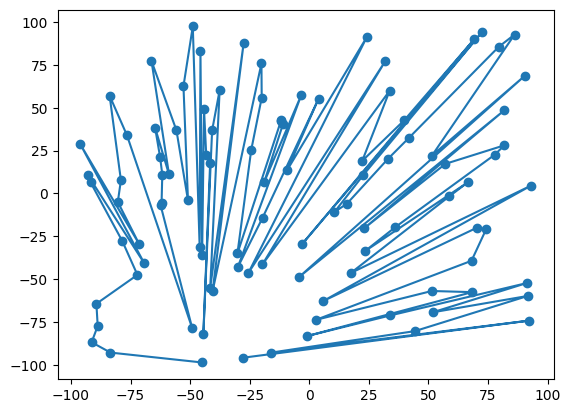

In [72]:
pts = points_a
sorted_pts = get_sorted(pts)
plt.plot(*zip(*sorted_pts))
plt.scatter(*zip(*pts))
plt.show()